# APRENDIZAJE AUTOMÁTICO
# Práctica 5: Regresión Logística Multiclase y Redes Neuronales
### Autor: Jiménez Omeñaca, David
### NIP:   825068   
### Fecha: 10/03/2025
---

---
## 0. Carga de datos de MNIST

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Load data from https://www.openml.org/
dataset = "mnist_784"
X, y = fetch_openml(dataset, version=1, return_X_y=True, as_frame=False, parser="pandas")
X = X / 255.0  # Escalar los datos entre 0 y 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000, shuffle=False)

print('X_train.shape:', X_train.shape)
print('y_train.shape:', y_train.shape)
print('X_test.shape:', X_test.shape)
print('y_test.shape:', y_test.shape)


X_train.shape: (60000, 784)
y_train.shape: (60000,)
X_test.shape: (10000, 784)
y_test.shape: (10000,)


In [2]:
from enum import IntFlag
from typing import Dict
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, balanced_accuracy_score

class Models:
    """
    A class to represent a collection of models and their computed metrics.

    This class is used to store, append, sort, and display metrics computed for multiple models.
    """
    
    def __init__(self):
        """
        Initializes an empty DataFrame to store model metrics.
        """
        self.df = pd.DataFrame()
    
    def append(self, model: pd.DataFrame):
        """
        Appends a new model's metrics to the collection.

        Parameters
        ----------

        model (pd.DataFrame) : A DataFrame containing the metrics of a single model.
        """
        self.df = pd.concat([self.df, model], axis=0, ignore_index=True)
    
    def sort(self, by: str, ascending: bool = True):
        """
        Sorts the stored models by a specified column.

        Parameters
        ----------

        by (str) : The column name by which to sort the models.
        ascending (bool, optional) : Whether to sort in ascending order. Defaults to True.
        """
        self.df = self.df.sort_values(axis=0, ascending=ascending, by=by)
    
    def print(self) -> pd.DataFrame:
        """
        Returns the stored DataFrame of model metrics.

        Returns
        -------

        pd.DataFrame : The DataFrame containing all appended model metrics.
        """
        return self.df


class ClassificationMetricsFlags(IntFlag):

    MEAN_PRECISSION = 1 << 0
    MEAN_RECALL = 1 << 1
    ACCURACY = 1 << 3
    BALANCED_ACCURACY = 1 << 4

class ClassificationMetrics():

    def __init__(self, y_real, y_pred, flags):
        self.y_real = y_real
        self.y_pred = y_pred
        self.flags = flags
        self.confusion_matrix = confusion_matrix(y_real, y_pred)
    
    def Mean_Precission(self):
        return precision_score(self.y_real, self.y_pred, average='weighted')

    def Mean_Recall(self):
        return recall_score(self.y_real, self.y_pred, average='weighted')

    def Accuracy(self):
        return accuracy_score(self.y_real, self.y_pred)
    
    def BalancedAccuracy(self):
        return balanced_accuracy_score(self.y_real, self.y_pred)
    
    def compute_metrics(self, name:str, r:int, beta:0.5) -> Dict[str, float]:
        metrics = {
            f'mean_prec_{name}': [round(self.Mean_Precission(), r)] if self.flags & ClassificationMetricsFlags.MEAN_PRECISSION else [],
            f'mean_recall_{name}': [round(self.Mean_Recall(), r)] if self.flags & ClassificationMetricsFlags.MEAN_RECALL else [],
            f'accuracy_{name}' : [round(self.Accuracy(), r)] if self.flags & ClassificationMetricsFlags.ACCURACY else [],
            f'bal_acc_{name}': [round(self.BalancedAccuracy(), r)] if self.flags & ClassificationMetricsFlags.BALANCED_ACCURACY else [],
        }
        return metrics
    
class LogisticMultiClassModel():
    def __init__(self, x_train, y_train, x_test, y_test, model, metrics, name):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.model = model
        self.metrics = metrics
        self.name = name
        import time
        now = time.time()
        self.model.fit(self.x_train, self.y_train)
        self.time = time.time() - now

    def k_fold_cross_validation(self, param_name, param_range, title="", k=5):
        from sklearn.model_selection import GridSearchCV
        import matplotlib.pyplot as plt
        parameter_grid = {param_name: param_range}
        grid = GridSearchCV(self.model, parameter_grid, cv=k, scoring='accuracy', return_train_score=True, n_jobs=-1)
        grid.fit(self.x_train, self.y_train)
        grid_train_errors = grid.cv_results_['mean_train_score']
        grid_test_errors = grid.cv_results_['mean_test_score']

        plt.plot(param_range, grid_train_errors, label='Train')
        plt.plot(param_range, grid_test_errors, label='Validation')
        plt.xscale('log')
        plt.legend()
        plt.title(title)
        plt.show()

        return (grid.best_params_, grid.best_estimator_)

    def compute_metrics(self, r=2):
        import time
        now = time.time()
        y_pred_train = self.model.predict(self.x_train)
        y_pred_test = self.model.predict(self.x_test)
        self.time_predict = time.time() - now
        train_metrics = ClassificationMetrics(self.y_train, y_pred_train, self.metrics)
        train_metrics = train_metrics.compute_metrics("train", r, 0.5)

        test_metrics = ClassificationMetrics(self.y_test, y_pred_test, self.metrics)
        test_metrics = test_metrics.compute_metrics("test", r, 0.5)

        metrics = {"Name": self.name, "Fit time":self.time, "Predict time":self.time_predict, **train_metrics, **test_metrics}
        metrics = {a:b for (a,b) in metrics.items() if b}
        metrics 

        return pd.DataFrame(metrics)
    
    def plot_example_real_vs_pred(self, predicted:str, real:str):
        y_pred = self.model.predict(self.x_test)
        idx = np.where((y_pred == predicted) & (self.y_test == real))[0]
        if len(idx) == 0:
            print("No se encontraron ejemplos con las características especificadas")
            return
        idx = idx[0]
        example = self.x_test[idx].flatten().reshape(28, 28)
        import matplotlib.pyplot as plt
        plt.imshow(example, cmap='gray')
        plt.title(f"Real: {real}, Predicted: {predicted}")

    def plot_confusion_matrix(self):
        from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
        y_pred = self.model.predict(self.x_test)
        conf = confusion_matrix(self.y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=conf)
        disp.plot()
        disp.ax_.set_title(self.name)
        
       

In [3]:
models = Models()
flags = ClassificationMetricsFlags.MEAN_PRECISSION | ClassificationMetricsFlags.MEAN_RECALL | ClassificationMetricsFlags.ACCURACY | ClassificationMetricsFlags.BALANCED_ACCURACY

## Bayes Ingenuo

Vamos a encontrar, utilizando `GridSearch` el mejor parámetro de regularización para un modelo de Bayes Ingenuo. Para ello, vamos a probar diferentes métodos:

### Bayes Ingenuo Gaussiano

Comenzamos suponiendo una verosimilitud gaussiana utilizando la función `GaussianNB`. Buscamos el valor óptimo del parámetro `var_smoothing`, que se representa como:
$$
\sigma^2_c = \sigma^2_c + \text{var\_smoothing}\cdot \max(\sigma^2)
$$

In [ ]:
from sklearn.naive_bayes import GaussianNB

mod_1_gauss = GaussianNB()

model_1_gauss = LogisticMultiClassModel(X_train, y_train, X_test, y_test, mod_1_gauss, flags, "Gaussian NB")


(best_value, best_model) = model_1_gauss.k_fold_cross_validation('var_smoothing', np.logspace(-6, 1, 10), "Gaussian NB")


Aquí podemos ver que el valor óptimo es:

In [ ]:
print("Best smoothing parameter: ", best_value)

Ajustamos y añadimos el mejor modelo obtenido

In [ ]:
model_1_gauss = LogisticMultiClassModel(X_train, y_train, X_test, y_test, best_model, flags, "Best Gaussian NB")

models.append(model_1_gauss.compute_metrics(2))

Vemos que el modelo obtenido no es muy bueno. Esto se debe a que:
- Asumir que la verosimilitud de la intensidad de los píxeles sigue una normal no es muy adecuado.

### Bernoulli NB

Probamos ahora con el clasificador de Bernoulli que es más adecuado, debido a que funciona muy bien cuando los features son binarios. En nuestro caso, los píxeles son: o coloreados o sin colorear. En este caso, buscamos el mejor parámetro de suavizado $\alpha$

$$
P(x_j = 1 \mid Y = c) = \frac{N_{c, j} + \alpha}{N_c + 2\alpha}
$$


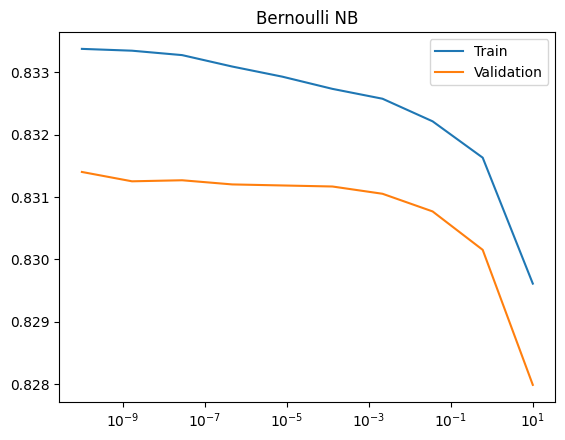

In [9]:
from sklearn.naive_bayes import BernoulliNB

mod_1_bern = BernoulliNB()

model_1_bern = LogisticMultiClassModel(X_train, y_train, X_test, y_test, mod_1_bern, flags, "Bernoulli NB")

(best_value, best_model) = model_1_bern.k_fold_cross_validation('alpha', np.logspace(-10, 1, 10), "Bernoulli NB")

El mejor valor obtenido de regularización es:

In [10]:
print("Best alpha parameter: ", best_value)

Best alpha parameter:  {'alpha': np.float64(1e-10)}


,Name,Fit time,Predict time,mean_prec_train,mean_recall_train,accuracy_train,bal_acc_train,mean_prec_test,mean_recall_test,accuracy_test,bal_acc_test
0,Best Bernoulli NB,0.549166,0.594151,0.83,0.83,0.83,0.83,0.84,0.84,0.84,0.84


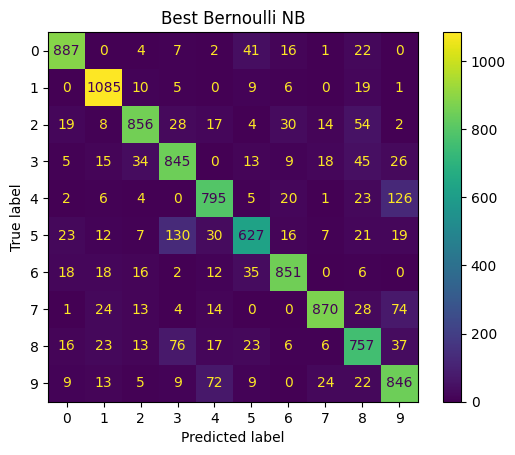

In [12]:
model_1_bern = LogisticMultiClassModel(X_train, y_train, X_test, y_test, best_model, flags, "Best Bernoulli NB")

models.append(model_1_bern.compute_metrics(2))

model_1_bern.plot_confusion_matrix()
model_1_bern.compute_metrics(2)

Aquí podemos apreciar mejores resultados que los obtenidos con el gaussiano.

-----
## 2. Análisis discriminante lineal

Ahora vamos a probar con tres los tres solvers disponibles: `lsqr`, `svd` y `eigen`.

Aquí vamos a hacer `GridSearch` sobre el parámetro que controla la regularización $\lambda$:

$$
\Sigma = (1-\lambda)\hat{\Sigma} + \lambda I
$$

### LSQR

Comenzamos con el solver `lsqr`:

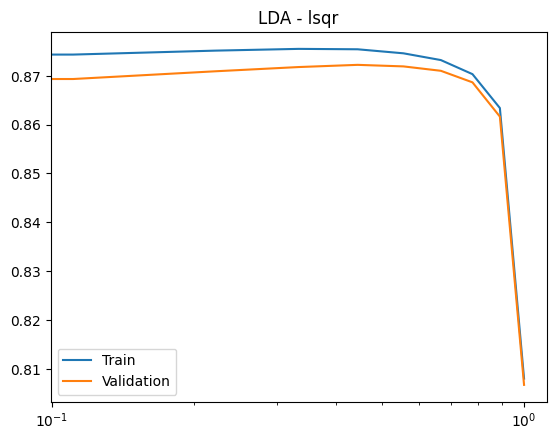

In [13]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

mod_2_lda = LinearDiscriminantAnalysis(solver='lsqr')

model_2_lda = LogisticMultiClassModel(X_train, y_train, X_test, y_test, mod_2_lda, flags, "LDA - lsqr")

(best_value, best_model) = model_2_lda.k_fold_cross_validation('shrinkage', np.linspace(0, 1, 10), "LDA - lsqr")

In [15]:
print("Best shrinkage parameter: ", best_value)

Best shrinkage parameter:  {'shrinkage': np.float64(0.4444444444444444)}


Añadimos el mejor modelo y ploteamos sus resultados

,Name,Fit time,Predict time,mean_prec_train,mean_recall_train,accuracy_train,bal_acc_train,mean_prec_test,mean_recall_test,accuracy_test,bal_acc_test
0,Best LDA - lsqr,1.548838,0.186171,0.88,0.87,0.87,0.87,0.88,0.88,0.88,0.88


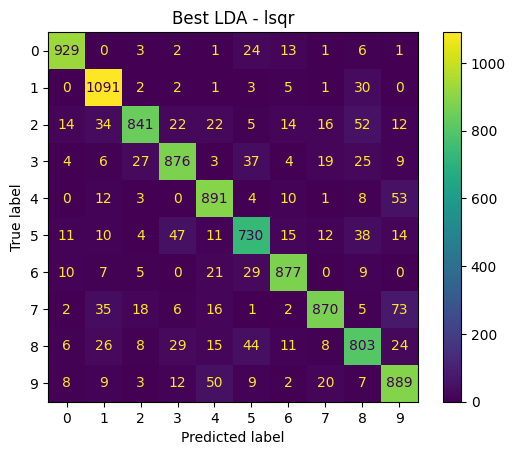

In [16]:
model_2_lda = LogisticMultiClassModel(X_train, y_train, X_test, y_test, best_model, flags, "Best LDA - lsqr")

models.append(model_2_lda.compute_metrics(2))

model_2_lda.plot_confusion_matrix()
model_2_lda.compute_metrics(2)

### SVD

Con `svd` como no se calcula la matriz de covarianza, no se puede realizar un ajuste con `GridSearch`. Vamos a ver el modelo ajustado

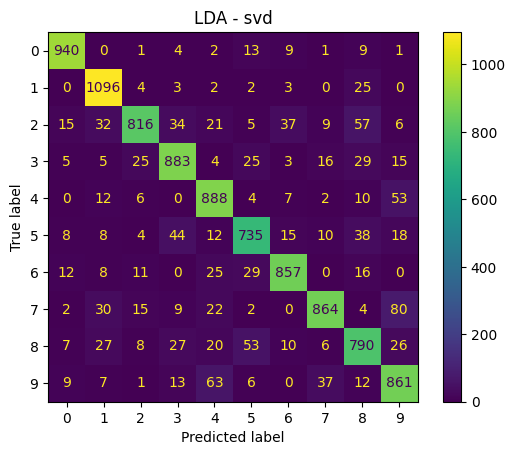

In [18]:
mod_2_lda_svd = LinearDiscriminantAnalysis(solver='svd')

model_2_lda_svd = LogisticMultiClassModel(X_train, y_train, X_test, y_test, mod_2_lda_svd, flags, "LDA - svd")

model_2_lda_svd.compute_metrics(2)

model_2_lda_svd.plot_confusion_matrix()

### eigen

Con este solver podemos realizar el `GridSearch` sobre el valor $\lambda$. Para evitar problemas numéricos por singularidades, es necesario al menos aplicar algo de regularización, es decir, tomar $\lambda>0$.

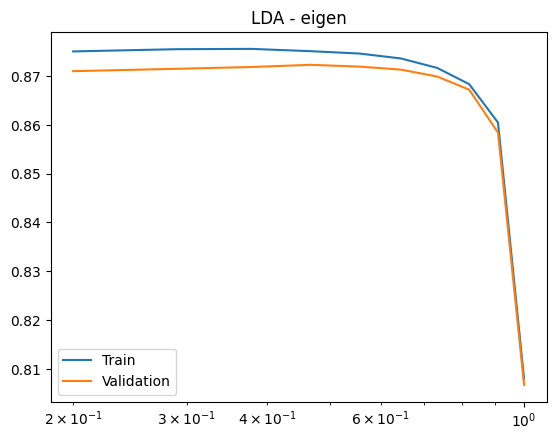

({'shrinkage': np.float64(0.4666666666666667)},
 LinearDiscriminantAnalysis(shrinkage=np.float64(0.4666666666666667),
                            solver='eigen'))

In [ ]:
model_2_lda_eigen = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')

model_2_lda_eigen = LogisticMultiClassModel(X_train, y_train, X_test, y_test, model_2_lda_eigen, flags, "LDA - eigen")

(best_param, best_model) = model_2_lda_eigen.k_fold_cross_validation('shrinkage', np.linspace(0.2, 1, 10), "LDA - eigen")

In [24]:
print("Best shrinkage parameter: ", best_param)

NameError: name 'best_param' is not defined

In [ ]:
model_2_lda_eigen = LogisticMultiClassModel(X_train, y_train, X_test, y_test, best_model, flags, "Best LDA - eigen")

models.append(model_2_lda_eigen.compute_metrics(2))

model_2_lda_eigen.plot_confusion_matrix()
model_2_lda_eigen.compute_metrics(2)

----

## Bayes completo

Ahora vamos a terminar ajustando modelos usando la técnica de **QDA**. Aquí, el parámetro de regularización `reg_param` realiza:
$$
\Sigma = (1-\text{reg\_param})\Sigma + I\cdot\text{reg\_param}
$$

In [29]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

mod_3_qda = QuadraticDiscriminantAnalysis(reg_param=0.1)

model_3_qda = LogisticMultiClassModel(X_train, y_train, X_test, y_test, mod_3_qda, flags, "QDA")

model_3_qda.k_fold_cross_validation('reg_param', np.linspace(0.1, 1, 10), "QDA")

KeyboardInterrupt: 

## Conclusiones finales

Analizamos todos los modelos de forma conjunta

In [ ]:
models.sort('accuracy_test', ascending=False)
models.print()

Aquí observamos que el mejor modelo con diferencia es el de redes neuronales con capa oculta, debido a la dimensión del modelo. Por otro lado, también vemos que el optimizador `saq` ha obtenido los segundos mejores resultados, tanto en multinomial como en *OvA*.

In [ ]:
models.df.to_csv("results_p4.csv")